In [81]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Random

In [82]:
include("rollout.jl")
include("testfns.jl")

TestGramacyLee (generic function with 1 method)

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

In [83]:
# Global parameters
MAX_SGD_ITERS = 100
BATCH_SIZE = 5
MC_SAMPLES = 50
HORIZON = 0
BUDGET = 1;

### 1. Generate low-discrepancy sequence for Quasi-Monte Carlo

In [84]:
# Setup toy problem
testfn = TestFunction(
    1, [0. 1.], [.5],
    x -> 0.,
    ∇x -> [0.]
)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
random_number_stream = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
# random_number_stream = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

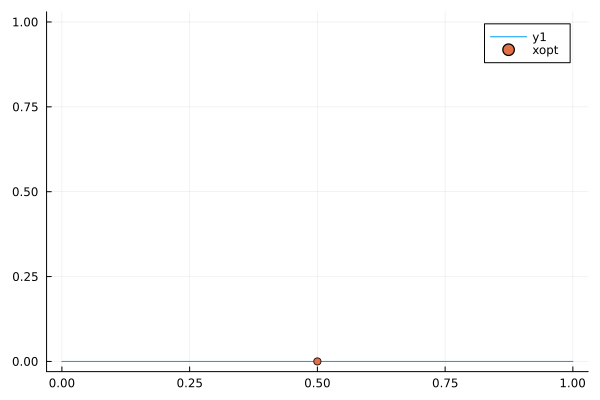

In [85]:
tplot(testfn)

### 2. Gather initial samples/experimental data

In [86]:
# Gather initial samples/experimental data
N, θ = 1, [.05]
X = [0., 1.]
X = reshape(X, 1, length(X))
ψ = kernel_matern52(θ);

### 3. Construct the ground truth surrogate model

In [87]:
sur = fit_surrogate(ψ, X, testfn.f)
# θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, testfn.f);

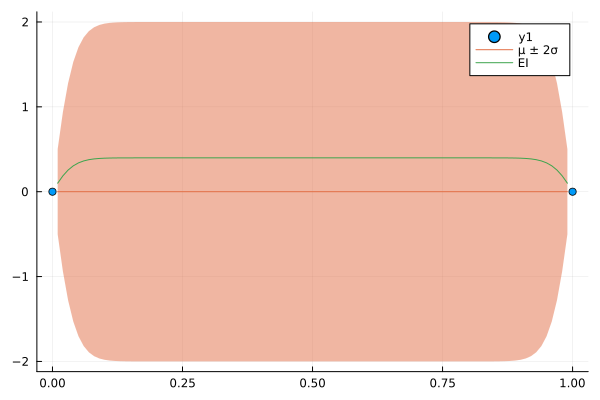

In [88]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
scatter(sur.X', sur.y)
plot!(domain, [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain], label="μ ± 2σ")
plot!(domain, [sur([x]).EI for x in domain], label="EI")

### 4. Setup hyperparameters for stochastic gradient descent

In [89]:
λ = 1e-1; # Vanilla stochastic gradient descent

### 5. While budget has not been exhausted
Each location in our minibatch is going to be our $x^0$ that serves as our deterministic start location. Then, we perform rollout from that point forward, computing several sample trajectories to then be averaged.

In [90]:
rollout_ei = []
∇rollout_ei = []

dense_domain = domain
println("Total '|'s => $(length(dense_domain))")
for x0 in dense_domain
    print("|$x0")
    # Grab each input location and convert to a column vector
    x0 = [x0]

    αx, ∇αx = 0., [0.]
    # Monte-carlo integrate trajectory for x0
    for sample in 1:MC_SAMPLES
        # Make a copy of our surrogate to pass to the trajectory struct
        # for fantasized computations
        fsur = Base.deepcopy(sur)
        fantasy_ndx = size(fsur.X, 2) + 1

        # Rollout trajectory
        T = Trajectory(fsur, x0, fantasy_ndx; h=HORIZON)
        rollout!(T, lbs, ubs; rnstream=random_number_stream[sample,:,:])

        # Evaluate rolled out trajectory
        αx += α(T)
        ∇αx += ∇α(T)
    end # endfor sample

    # Average trajectories
    αx /= MC_SAMPLES
    ∇αx /= MC_SAMPLES

    # Update history
    push!(rollout_ei, αx)
    push!(∇rollout_ei, first(∇αx))
end # endfor x0

Total '|'s => 99
|0.01|0.02|0.03|0.04|0.05|0.06|0.07|0.08|0.09|0.1|0.11|0.12|0.13|0.14|0.15|0.16|0.17|0.18|0.19|0.2|0.21|0.22|0.23|0.24|0.25|0.26|0.27|0.28|0.29|0.3|0.31|0.32|0.33|0.34|0.35|0.36|0.37|0.38|0.39|0.4|0.41|0.42|0.43|0.44|0.45|0.46|0.47|0.48|0.49|0.5|0.51|0.52|0.53|0.54|0.55|0.56|0.57|0.58|0.59|0.6|0.61|0.62|0.63|0.64|0.65|0.66|0.67|0.68|0.69|0.7|0.71|0.72|0.73|0.74|0.75|0.76|0.77|0.78|0.79|0.8|0.81|0.82|0.83|0.84|0.85|0.86|0.87|0.88|0.89|0.9|0.91|0.92|0.93|0.94|0.95|0.96|0.97|0.98|0.99

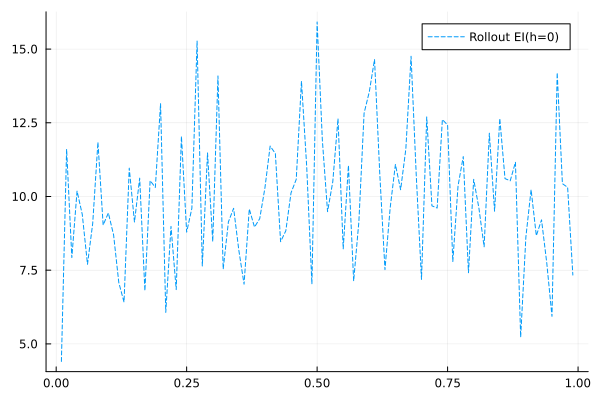

In [95]:
plot(
    dense_domain,
    rollout_ei + [sur([x]).EI for x in dense_domain],
    label="Rollout EI(h=$HORIZON)",
    linestyle=:dash
)
# plot!(∇rollout_ei, label="Rollout ∇EI(h=1)")

In [62]:
rollout_ei

153-element Vector{Any}:
 0.2510826271859818
 0.3380936028634498
 0.23445414063375192
 0.3003627331381772
 0.3518308539799893
 0.3435522844064268
 0.34333571256753687
 0.29476499173479637
 0.2196491113752868
 0.3826010139570032
 0.3360433264191071
 0.28410465528209916
 0.3730632667370988
 ⋮
 0.00642880676983078
 0.0029736359701118026
 0.01631894808914921
 0.006703834943829711
 0.013708987091299269
 0.01538825662102637
 0.018478575841860773
 0.0026812894763904756
 0.03260472687431076
 0.017838153718254115
 0.06192430883715794
 0.21627909838085174